In [1]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
np.random.seed(12345)
import random
random.seed(12345)
from sklearn.svm import SVC

In [2]:
feature_files = glob('static/features/dogcentric/conv5/*.pkl')
len(feature_files)

209

In [3]:
# Tips from http://robotics.ait.kyushu-u.ac.jp/~yumi/db/first_dog.html
# (1) In experiments, we randomly selected half video sequences of each activity from our dataset as training dataset and use the rest of sequences for the testing. 
# In case that the number of videos (=N) is odd number, we used (N-1) / 2 videos for training.

dataset = {}
for ff in tqdm(feature_files):
    tmp = ff.split('/')
    activity = tmp[-1].split('_')[0]
    if activity in dataset:
        dataset[activity].append(ff)
    else:
        dataset[activity] = [ff]



dataset.keys()

training_videos = []
testing_videos = []
for activity in dataset:
    videos = dataset[activity]
    N = len(videos)
    selected = random.sample(range(N), int((N-N%2)/2))
    for i in range(N):
        if i in selected:
            training_videos.append(videos[i])
        else:
            testing_videos.append(videos[i])

len(training_videos)

100%|██████████| 209/209 [00:00<00:00, 187952.30it/s]


101

In [4]:
from sklearn.cluster import KMeans
K = 32

def computeVocabulary(training_videos, K=16):
    features = []
    for v in tqdm(training_videos):
        ft = pickle.load(open(v, 'rb'))
        for f in ft:
            features.append(f[0])
    k = KMeans(n_clusters=K, init='k-means++').fit(features)
    return k

vocab = computeVocabulary(training_videos, K=K)

def encode(testing_videos, vocab):
    features = []
    codes = []
    for v in tqdm(testing_videos):
        ft = pickle.load(open(v, 'rb'))
        obj = {'video': v, 'code': []}
        code = []
        for f in ft:
            code.extend(vocab.predict([f[0]]))
        obj['code'] = code
        codes.append(obj)
    return codes

codes = encode(training_videos, vocab)
test_codes = encode(testing_videos, vocab)

100%|██████████| 108/108 [00:00<00:00, 116.67it/s]


In [5]:
def hist(code):
    v = np.zeros(K)
    for c in code:
        v[c] += 1
    return v

hist(codes[0]['code'])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
keys = list(dataset.keys())
labels = {}
for i, k in enumerate(keys):
    labels[k] = i
def label(video_path):
    return labels[video_path.split('/')[-1].split('_')[0]]

label(codes[100]['video'])

9

In [7]:
# Do classification with SVM
svc = SVC(gamma='auto',probability=True)

X = np.zeros((len(codes), K))
y = np.zeros((len(codes),))
for i, code in tqdm(enumerate(codes)):
    X[i] = hist(code['code'])
    y[i] = label(code['video'])

svc.fit(X,y)

X_test = np.zeros((len(test_codes), K))
y_test = np.zeros((len(test_codes),))
for i, code in tqdm(enumerate(test_codes)):
    X_test[i] = hist(code['code'])
    y_test[i] = label(code['video'])

y_pred = svc.predict(X_test)
y_pred, y_test

101it [00:00, 32714.86it/s]
108it [00:00, 27224.28it/s]


(array([4., 3., 7., 3., 0., 0., 4., 4., 4., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 6., 7., 6., 1., 2., 4., 3., 3., 4., 8., 3., 4.,
        3., 3., 1., 3., 4., 3., 0., 9., 4., 4., 4., 1., 0., 9., 9., 0., 0.,
        5., 9., 7., 4., 1., 9., 7., 7., 0., 3., 6., 6., 3., 9., 6., 4., 4.,
        3., 3., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 4., 7., 6., 4.,
        4., 8., 8., 7., 8., 8., 7., 8., 8., 8., 6., 4., 8., 9., 9., 9., 4.,
        9., 4., 9., 9., 9., 3.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
        8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 9., 9., 9., 9.,
        9., 9., 9., 9., 9., 9.]))

In [8]:
from sklearn.metrics import confusion_matrix, average_precision_score
cnf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

In [9]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 2  0  0  2  4  0  0  1  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  2  1  0  0]
 [ 0  1  0  7  4  0  0  0  1  0]
 [ 4  1  0  0  3  0  0  0  0  3]
 [ 0  1  0  0  1  1  0  2  0  2]
 [ 1  0  0  4  2  0  4  1  0  1]
 [ 0  0  0  0  2  0  1 11  0  0]
 [ 0  0  0  0  2  0  1  2  8  0]
 [ 0  0  0  1  2  0  0  0  0  7]]
Normalized confusion matrix
[[0.22 0.   0.   0.22 0.44 0.   0.   0.11 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.2  0.2  0.   0.   0.   0.4  0.2  0.   0.  ]
 [0.   0.08 0.   0.54 0.31 0.   0.   0.   0.08 0.  ]
 [0.36 0.09 0.   0.   0.27 0.   0.   0.   0.   0.27]
 [0.   0.14 0.   0.   0.14 0.14 0.   0.29 0.   0.29]
 [0.08 0.   0.   0.31 0.15 0.   0.31 0.08 0.   0.08]
 [0.   0.   0.   0.   0.14 0.   0.07 0.79 0.   0.  ]
 [0.   0.   0.   0.   0.15 0.   0.08 0.15 0.62 0.  ]
 [0.   0.   0.   0.1  0.2  0.   0.   0.   0.   0.7 ]]


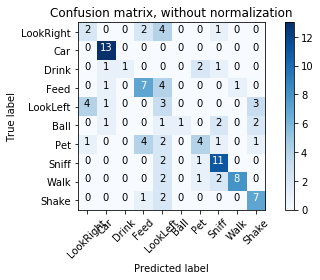

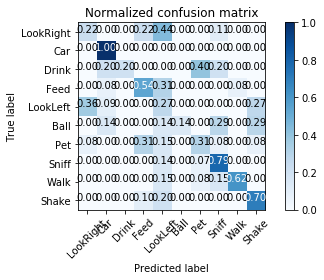

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=keys,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=keys, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [11]:
y_pred2 = svc.predict_proba(X_test)
y_pred2

array([[0.18, 0.04, 0.06, ..., 0.12, 0.07, 0.08],
       [0.14, 0.02, 0.05, ..., 0.14, 0.04, 0.05],
       [0.07, 0.04, 0.05, ..., 0.22, 0.19, 0.07],
       ...,
       [0.15, 0.02, 0.03, ..., 0.11, 0.03, 0.29],
       [0.12, 0.03, 0.03, ..., 0.2 , 0.05, 0.2 ],
       [0.15, 0.02, 0.04, ..., 0.14, 0.04, 0.06]])

In [12]:
print('Score: {:.2f} %'.format(svc.score(X_test, y_test) * 100))

Score: 52.78 %
